## Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
from tensorboard import notebook
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, roc_auc_score
from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination

%load_ext tensorboard

In [3]:
data = pd.read_csv("../solutions/galaxyquasar.csv")

In [5]:
#Define the colors and classes

ug = np.array(data["u"] - data["g"])
gr = np.array(data["g"] - data["r"])
ri = np.array(data["r"] - data["i"])
iz = np.array(data["i"] - data["z"])

colors = np.vstack((ug, gr, ri, iz)).T
classes = np.array(data["class"] == "QSO", dtype=int)

In [7]:
#Train and test split
train_X, test_X, train_y, test_y = train_test_split(colors, classes, train_size=0.7)
train_X = train_X[:, :]
test_X = test_X[:, :]

#Validation and test split
val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, train_size=0.5)

#Scaling
scaler = StandardScaler()
train_X_s = scaler.fit_transform(train_X)
val_X_s = scaler.transform(val_X)
test_X_s = scaler.transform(test_X)

## Neural network hyperparameter tuning

In [9]:
# %%sh
# rm -rf ./logs/

In [11]:
#Define hyperparameters, metrics and the log file

HP_NUM_UNITS = hp.HParam("num_units", hp.Discrete([30, 50, 100]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.2, 0.5, 0.8]))
HP_OPTIMIZER = hp.HParam("optimizer", hp.Discrete(["adam", "adagrad"]))
HP_ACTIVATION = hp.HParam("activation", hp.Discrete(["relu", "sigmoid"]))

METRIC_ACCURACY = "accuracy"
METRIC_RECALL = "recall"

with tf.summary.create_file_writer("logs/hparam_tuning").as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_ACTIVATION],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy"), hp.Metric(METRIC_RECALL, display_name="Recall")],
  )

In [13]:
#Define the model

def train_test_model(hparams):
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=train_X_s.shape[-1]),
        keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION]),
        keras.layers.Dropout(hparams[HP_DROPOUT]),
        keras.layers.Dense(units=1, activation="sigmoid")
    ])
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), 
                  optimizer=hparams[HP_OPTIMIZER], 
                  metrics=[keras.metrics.BinaryAccuracy(name="binary accuracy"), keras.metrics.Recall(name="recall")])
    
    fit = model.fit(train_X_s, train_y, epochs=3, validation_data=(val_X_s, val_y), use_multiprocessing=True)

    _, accuracy, recall = model.evaluate(test_X_s, test_y)
    
    return accuracy, recall

In [15]:
#Define the run function

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # Record the values used in this trial
      
    accuracy, recall = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    tf.summary.scalar(METRIC_RECALL, recall, step=1)

In [17]:
keras.backend.clear_session()

In [25]:
#Run the sessions to tune the hyperparameters

session_num = 0

for activation in HP_ACTIVATION.domain.values:
    for optimizers in HP_OPTIMIZER.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for num_units in HP_NUM_UNITS.domain.values:
                hparams = {HP_NUM_UNITS: num_units,
                          HP_DROPOUT: dropout_rate,
                          HP_OPTIMIZER: optimizers,
                          HP_ACTIVATION: activation}
                
                run_name = "run_" + str(session_num)
                print('--- Starting trial: ' + str(run_name))
                print({h.name: hparams[h] for h in hparams})
            
                run('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1

--- Starting trial: run_0
{'num_units': 30, 'dropout': 0.2, 'optimizer': 'adagrad', 'activation': 'relu'}
Epoch 1/3
1094/1094 [==============================] - 3s 2ms/step - loss: 0.5156 - binary accuracy: 0.8861 - recall: 0.6316 - val_loss: 0.4621 - val_binary accuracy: 0.9360 - val_recall: 0.7664
Epoch 2/3
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4372 - binary accuracy: 0.9201 - recall: 0.7024 - val_loss: 0.4117 - val_binary accuracy: 0.9539 - val_recall: 0.8549
Epoch 3/3
235/235 [==============================] - 0s 1ms/step - loss: 0.3711 - binary accuracy: 0.9605 - recall: 0.8714
--- Starting trial: run_1
{'num_units': 50, 'dropout': 0.2, 'optimizer': 'adagrad', 'activation': 'relu'}
Epoch 1/3
1094/1094 [==============================] - 3s 2ms/step - loss: 0.5375 - binary accuracy: 0.8683 - recall: 0.7066 - val_loss: 0.4731 - val_binary accuracy: 0.9420 - val_recall: 0.9234
Epoch 2/3
1094/1094 [==============================] - 2s 2ms/step - loss: 0.441

In [52]:
%tensorboard --logdir logs/hparam_tuning
notebook.list()

Reusing TensorBoard on port 6006 (pid 6148), started 0:38:53 ago. (Use '!kill 6148' to kill it.)

Known TensorBoard instances:
  - port 6006: logdir logs/hparam_tuning (started 0:38:53 ago; pid 6148)


## Comparison between NN and GMM classifier

### Tuned neural network

In [54]:
#Best accuracy model

best_num_units = 50
best_dropout = 0.5
best_optimizer = "adam"
best_activation = "relu"

#Best recall model

# best_num_units = 100
# best_dropout = 0.2
# best_optimizer = "adagrad"
# best_activation = "relu"

In [56]:
keras.backend.clear_session()

In [58]:
model_best_hp = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=train_X_s.shape[-1]),
    keras.layers.Dense(best_num_units, activation=best_activation),
    keras.layers.Dropout(best_dropout),
    keras.layers.Dense(units=1, activation="sigmoid")
])

model_best_hp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_best_hp.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=best_optimizer, metrics=["accuracy"])
fit = model_best_hp.fit(train_X_s, train_y, epochs=15, validation_data=(val_X_s, val_y), use_multiprocessing=True)

Epoch 1/15
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1829 - accuracy: 0.9581 - val_loss: 0.0734 - val_accuracy: 0.9840
Epoch 2/15
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0888 - accuracy: 0.9806 - val_loss: 0.0724 - val_accuracy: 0.9835
Epoch 3/15
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0835 - accuracy: 0.9812 - val_loss: 0.0701 - val_accuracy: 0.9836
Epoch 4/15
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0798 - accuracy: 0.9820 - val_loss: 0.0684 - val_accuracy: 0.9831
Epoch 5/15
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9811 - val_loss: 0.0749 - val_accuracy: 0.9831
Epoch 6/15
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0794 - accuracy: 0.9818 - val_loss: 0.0751 - val_accuracy: 0.9837
Epoch 7/15
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0783 - accuracy: 0.9816 - val_loss: 0.0736 - val_accuracy:

235/235 [==============================] - 0s 1ms/step


Text(0, 0.5, 'True positive rate')

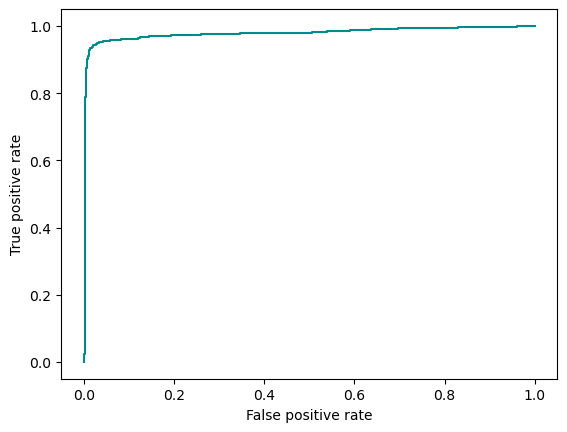

In [62]:
prob_test = model_best_hp.predict(test_X_s)

#ROC curve to select the threshold
fpr, tpr, th = roc_curve(test_y, prob_test)
best_th = th[np.argmax(tpr - fpr)]

plt.figure()
plt.plot(fpr, tpr, color="darkcyan")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [64]:
#Choose threshold in the upper left part of the ROC curve

th_pred = np.array(prob_test.flatten() > best_th, dtype=int)
comp, cont = completeness_contamination(th_pred, test_y)

C_test = confusion_matrix(test_y, th_pred)

print("Statistics for best threshold: \n")

print("Completeness = " + str(comp))
print("Contamination = " + str(cont))
print("Accuracy = " + str(accuracy_score(test_y, th_pred)))
print("AUC = " + str(roc_auc_score(test_y, prob_test)))
print("C = \n" + str(C_test))

Statistics for best threshold: 

Completeness = 0.9416419386745796
Contamination = 0.12096029547553093
Accuracy = 0.9746666666666667
AUC = 0.9791112678093751
C = 
[[6358  131]
 [  59  952]]


### GMM classifier

In [66]:
#CV for number of components

cv = GridSearchCV(GMMBayes(), {"n_components": np.arange(1, 15)}, cv=5)
cv.fit(train_X_s, train_y)
best_n = cv.best_params_["n_components"]
print("Best number of components = " + str(best_n))

Best number of components = 12


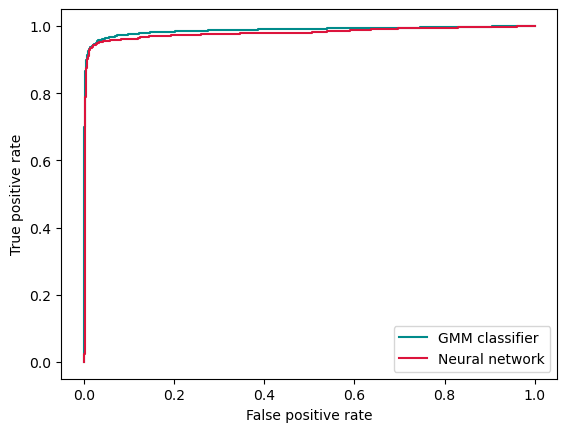

In [68]:
#GMM training and ROC curve

gmm = GMMBayes(best_n)
gmm.fit(train_X_s, train_y)

labels_gmm = gmm.predict(test_X_s)
prob_gmm = gmm.predict_proba(test_X_s)[:, 1]

fpr_gmm, tpr_gmm, th_gmm = roc_curve(test_y, prob_gmm)

plt.figure()
plt.plot(fpr_gmm, tpr_gmm, color="darkcyan", label="GMM classifier")
plt.plot(fpr, tpr, color="crimson", label="Neural network")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()

In [70]:
best_th_gmm = th_gmm[np.argmax(tpr_gmm - fpr_gmm)]
best_pred_gmm = np.array(prob_gmm >= best_th_gmm, dtype=bool)

comp_gmm, cont_gmm = completeness_contamination(best_pred_gmm, test_y)

print("Statistics for best threshold: \n")

print("Completeness = " + str(comp_gmm))
print("Contamination = " + str(cont_gmm))
print("Accuracy = " + str(accuracy_score(test_y, best_pred_gmm)))
print("AUC = " + str(roc_auc_score(test_y, best_pred_gmm)))
print("C = \n" + str(confusion_matrix(test_y, best_pred_gmm)))

Statistics for best threshold: 

Completeness = 0.9574678536102869
Contamination = 0.17546848381601363
Accuracy = 0.9668
AUC = 0.9628609109321274
C = 
[[6283  206]
 [  43  968]]


The results of the GMM classifier and of the neural network are comparable, so the NN isn't really needed for this problem.